### The approach

1. Decide on ML task: Regression or classification
2. Download the data
3. Understand it, explore it and visualize it
5. Feature selection and Feature extraction
6. Feature scaling
7. Train model
8. Predict
9. Evaluate

In [1]:
# Importing necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### Download the data

In [2]:
# Load the data from csv file (daily stock price of intel for the last 5 years)
data = pd.read_csv("intc.csv")

### Inspect the Data

In [3]:
# Inspect the data
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,News Sentiments
0,24-07-2017,30.541890,30.603448,30.234098,30.339626,16146300,0.0,0,3.217471474
1,25-07-2017,30.383590,30.550680,30.251681,30.489119,18096700,0.0,0,0.29985157
2,26-07-2017,30.515501,30.752942,30.418766,30.559471,15499300,0.0,0,1.463964503
3,27-07-2017,30.585849,30.999173,30.489114,30.752939,43062800,0.0,0,1.610142503
4,28-07-2017,30.893656,31.535625,30.779332,31.051950,36291500,0.0,0,-1.027758565


In [4]:
# Check the shape of the data
data.shape

(1258, 9)

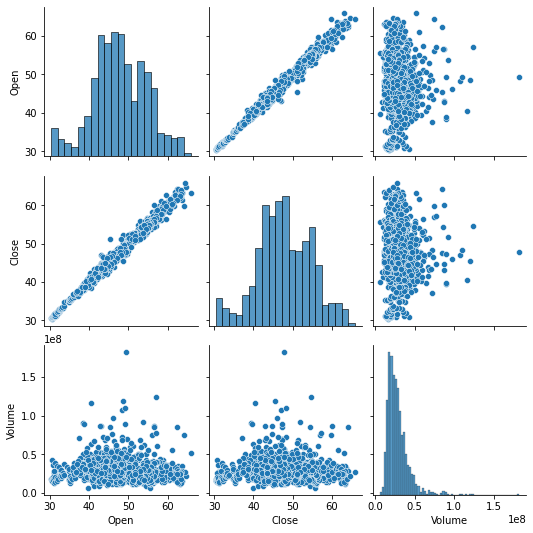

In [5]:
#The data can be visualized in a pairplot as follows

import seaborn as sns
sns.pairplot(data[['Open','Close','Volume']])

### Generating Returns and Target Values

Let's say we want to predict the next days movement: up or down. What kind of ML problem would it be? It would be a classification task. And for that purpose, we need to create our target values. Let's create it.

In [6]:
# Generate log returns
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))

If the next day is up day, we will designate it with 1, else if it is a down day, we will mark it with -1.

In [7]:
# Create target values
data['target'] = np.where(data.returns.shift(-1) > 0, 1, -1)

In [8]:
# Count the values in the target column
data['target'].value_counts()

 1    645
-1    613
Name: target, dtype: int64

### Feature Selection

From the available data, we wish to learn a model to predict the next day's movement. But let's first understand which of these features can actually be used. Our intuition says that `Close` price plays a major role in determining the next days movement. So we'll consider it. `Volume` and `News Sentiments` may also have an impact and therefore we will keep those columns as well. The other columns may be ignored.

When dealing with large number of columns, where the user is unsure of what features to keep and what not, one often carries out a preliminary feature selection exercise. However, note that domain expertise in feature selection plays a cruicial role.

### Feature Extraction

After ignoring the irrelevant features, we are left with only three variables, viz `Close`, `Volume` and `News Sentiments`. Our intuition says that only these two features might not be able to capture to intricacies of the stock movement. We need additional useful features. We will create or extract new features based on the existing ones.

Let's try to create new features. We will consider the following quantitative features.

- Rolling standard deviation
- Rolling moving average of close price
- Rolling percentage change
- Rolling moving average of volume
- Difference between close and open

In [9]:
# Creating features
features_list = ["News Sentiments"]

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Feature based on volume
col_name = 'vma_4'
data[col_name] = data['Volume'].rolling(4).mean()
features_list.append(col_name)

# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

This process of extracting information from the existing features is called feature extraction. We now have a handful of features as shown below. 

In [10]:
features_list

['News Sentiments',
 'std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'vma_4',
 'co']

We'll be using these features to predict the next days movement. We won't be using the `Close` and `Volume` columns anymore. Now is the time to generate our train and test data.

As we are dealing with time-series data, we need to split our data set in such a way that it doesn't have a lookahead bias. But before we do it, can you think of any potential issue. Again, resorting to our old friend `.info()` will help us see for any potential issues.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1258 non-null   object 
 1   Open             1258 non-null   float64
 2   High             1258 non-null   float64
 3   Low              1258 non-null   float64
 4   Close            1258 non-null   float64
 5   Volume           1258 non-null   int64  
 6   Dividends        1258 non-null   float64
 7   Stock Splits     1258 non-null   int64  
 8   News Sentiments  1258 non-null   object 
 9   returns          1257 non-null   float64
 10  target           1258 non-null   int64  
 11  std_5            1254 non-null   float64
 12  std_10           1249 non-null   float64
 13  std_15           1244 non-null   float64
 14  ma_10            1249 non-null   float64
 15  ma_15            1244 non-null   float64
 16  ma_20            1239 non-null   float64
 17  ma_25         

There are many null values in the features. We need to get rid of them before we move further.

In [12]:
# Removing nan values
data.dropna(inplace=True)

In [13]:
data[features_list+['target']].head()

,News Sentiments,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co,target
24,1.962872649,0.100126,0.555820,0.663630,31.182269,31.505367,31.622700,31.425884,0.000579,-0.014274,-0.046779,18693650.0,-0.132903,-1
25,2.564720845,0.022060,0.441909,0.657485,31.032533,31.400227,31.598081,31.440310,-0.000287,-0.010301,-0.038000,17347425.0,-0.115179,1
26,-2.285617635,0.030436,0.325405,0.630273,30.920009,31.300994,31.538312,31.451592,0.000580,-0.005421,-0.030413,16396325.0,0.194923,1
27,-1.143725594,0.084056,0.161128,0.554882,30.838496,31.200580,31.472880,31.465730,0.006339,0.006918,-0.007935,17462100.0,0.124041,1
28,0.956926206,0.156804,0.142818,0.506731,30.829635,31.137378,31.409973,31.478508,0.012075,0.011788,0.001774,17872100.0,0.115182,1


In [14]:
#Correlation coefficients
corr = data[features_list].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
std_5,1.00,0.67,0.51,0.21,0.22,0.23,0.24,-0.22,-0.22,-0.16,0.66,-0.05
std_10,0.67,1.00,0.83,0.20,0.22,0.24,0.25,-0.12,-0.22,-0.25,0.59,0.02
std_15,0.51,0.83,1.00,0.17,0.21,0.23,0.24,-0.09,-0.15,-0.21,0.48,0.00
ma_10,0.21,0.20,0.17,1.00,0.99,0.98,0.97,-0.11,-0.10,-0.05,-0.06,-0.05
ma_15,0.22,0.22,0.21,0.99,1.00,1.00,0.98,-0.13,-0.14,-0.12,-0.04,-0.05
ma_20,0.23,0.24,0.23,0.98,1.00,1.00,1.00,-0.13,-0.15,-0.16,-0.03,-0.05
ma_25,0.24,0.25,0.24,0.97,0.98,1.00,1.00,-0.13,-0.16,-0.17,-0.02,-0.05
pct_3,-0.22,-0.12,-0.09,-0.11,-0.13,-0.13,-0.13,1.00,0.71,0.55,-0.19,0.44
pct_6,-0.22,-0.22,-0.15,-0.10,-0.14,-0.15,-0.16,0.71,1.00,0.81,-0.24,0.30
pct_9,-0.16,-0.25,-0.21,-0.05,-0.12,-0.16,-0.17,0.55,0.81,1.00,-0.24,0.21


### Generating Training and Testing Datasets

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train , X_test,Y_train,Y_test = train_test_split(data[features_list].iloc[:-1],
                                                   data.iloc[:-1]['target'],
                                                   test_size= 0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((986, 13), (986,), (247, 13), (247,))

In [17]:
#The descriptive statistics of the features reveal that the order of magnitudes of the features are very different
data[features_list].describe()

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
count,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1.234000e+03,1234.000000
mean,0.826305,1.147023,1.394016,48.143361,48.131024,48.119657,48.107472,0.001476,0.002795,0.003970,2.880777e+07,0.009035
std,0.644280,0.786092,0.892981,6.490973,6.453161,6.415417,6.381783,0.035761,0.050691,0.060510,1.087040e+07,0.812314
min,0.022060,0.142818,0.294095,30.829635,30.983211,31.161004,31.349193,-0.193226,-0.238315,-0.232320,1.115745e+07,-4.383805
25%,0.438376,0.615768,0.773336,43.618280,43.656746,43.678696,43.744832,-0.015335,-0.021858,-0.026795,2.092840e+07,-0.417740
50%,0.643024,0.942104,1.131428,47.638610,47.603447,47.663084,47.731497,0.002842,0.006599,0.007575,2.667218e+07,0.026581
75%,1.004421,1.382559,1.689403,52.847999,52.754696,52.668811,52.607691,0.020739,0.030156,0.039133,3.383403e+07,0.432089
max,5.686916,5.901506,5.626518,63.560337,63.081724,62.628537,62.515755,0.143055,0.202942,0.185838,1.031650e+08,5.806564


In [18]:
#Scale the features as the order of magnitudes of the features are very different
from sklearn.preprocessing import StandardScaler

#Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train logistic regression model

In [19]:
# Create model
model = LogisticRegression()

# Train model
model.fit(X_train_scaled, Y_train)

LogisticRegression()

### Prediction and Model evaluation
Finally, we have arrived at the most interesting point, where we can predict. Let's do it.

In [20]:
# Predict on train dataset
Y_pred_train = model.predict(X_train_scaled)

In [21]:
print('Model accuracy on training data:', model.score(X_train_scaled, Y_train))

Model accuracy on training data: 0.7079107505070994


In [22]:
# Predict on test dataset
Y_pred = model.predict(X_test_scaled)

In [23]:
print('Model accuracy on testing data:', model.score(X_test_scaled, Y_test))

Model accuracy on testing data: 0.7368421052631579


In [24]:
# Another method to calculate accuracy
from sklearn.metrics import accuracy_score
print('Model accuracy on training data:', accuracy_score(Y_train, Y_pred_train))
print('Model accuracy on testing data:', accuracy_score(Y_test, Y_pred))

Model accuracy on training data: 0.7079107505070994
Model accuracy on testing data: 0.7368421052631579


In [25]:
# Printing confusion matrix
m = metrics.confusion_matrix(Y_test, Y_pred)
print(m)

[[91 40]
 [25 91]]


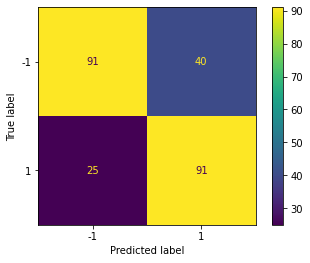

In [26]:
# Better visualization of a confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m,display_labels=model.classes_)
disp.plot()
plt.show()

In [27]:
# Printing classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.69      0.74       131
           1       0.69      0.78      0.74       116

    accuracy                           0.74       247
   macro avg       0.74      0.74      0.74       247
weighted avg       0.74      0.74      0.74       247

